In [1]:
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, UpSampling2D, Conv2D, Flatten, Dense, Reshape
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras import backend as K
import keras

import numpy as np
import matplotlib.pyplot as plt

from os import listdir
from os import system
import os
import random

import imageio

Using TensorFlow backend.


In [2]:
img_width, img_height = 16, 16

nb_epoch = 50
batch_size = 32

In [3]:
base_dir = '/home/niaki/Code/ImageNet/tiny-imagenet-200'

train_data_dir      = base_dir + '/tiny_train16'
validation_data_dir = base_dir + '/tiny_validation16'
test_data_dir       = base_dir + '/tiny_test16'

# train_descrs_dir      = base_dir + '/tiny_sifts/tiny_train16'
# validation_descrs_dir = base_dir + '/tiny_sifts/tiny_validation16'
# test_descrs_dir       = base_dir + '/tiny_sifts/tiny_test16'

In [4]:
def loading_data(data_dir):
    files = listdir(data_dir + '/class0')
    files.sort()

    images = []

    for file in files:
        image = imageio.imread(data_dir + '/class0/' + file)
    #     image = np.expand_dims(image, axis=0)
        images.append(image)

    images = np.array(images)
    images = images.astype(np.float64) / 255
    print(images.shape)
    return images

In [5]:
x_train = loading_data(train_data_dir)
x_validation = loading_data(validation_data_dir)

(157086, 16, 16, 3)
(3932, 16, 16, 3)


In [6]:
# def loading_descrs(descrs_dir):
#     files = listdir(descrs_dir + '/class0')
#     files.sort()

#     descrs = []

#     for file in files:
#         descr = np.load(descrs_dir + '/class0/' + file)
#         descrs.append(descr)

#     descrs = np.array(descrs)
#     print(descrs.shape)
#     return descrs

In [7]:
# y_train = loading_descrs(train_descrs_dir)
# y_validation = loading_descrs(validation_descrs_dir)

(157086, 128)
(3932, 128)


In [142]:
input_shape = (img_width, img_height, 3)
input_img = Input(shape=input_shape)

x = Conv2D(32, (3, 3), activation="relu", padding="same", trainable=False)(input_img)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Conv2D(32, (3, 3), activation="relu", padding="same", trainable=False)(x)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Conv2D(32, (3, 3), activation="relu", padding="same", trainable=False)(x)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Flatten(data_format="channels_last")(x)
encoded = Dense(128, activation="relu", trainable=False)(x)

x = Dense(128, activation="relu")(encoded)
x = Reshape((2, 2, 32))(x)
x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation="relu", padding="same")(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='rmsprop', metrics=['accuracy'], loss='mean_squared_error')

model_version_encoder = '0.0.5.1_encoder_relu_rmsprop_mse_generated'
encoder = load_model(base_dir + '/ae' + model_version_encoder + '.h5')
for i in range(len(encoder.layers)):
    autoencoder.get_layer(index=i).set_weights(encoder.get_layer(index=i).get_weights())

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        (None, 16, 16, 3)         0         
_________________________________________________________________
conv2d_185 (Conv2D)          (None, 16, 16, 32)        896       
_________________________________________________________________
max_pooling2d_88 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_186 (Conv2D)          (None, 8, 8, 32)          9248      
_________________________________________________________________
max_pooling2d_89 (MaxPooling (None, 4, 4, 32)          0         
_________________________________________________________________
conv2d_187 (Conv2D)          (None, 4, 4, 32)          9248      
_________________________________________________________________
max_pooling2d_90 (MaxPooling (None, 2, 2, 32)          0         
__________

In [6]:
# def fixed_generator(generator):
#     for batch in generator:
#         yield (batch, batch)

In [10]:
# train_datagen = ImageDataGenerator(
#         rescale=1./255#,
#         #shear_range=0.2,
#         #zoom_range=0.2,
#         #horizontal_flip=True
#         )
# test_datagen = ImageDataGenerator(rescale=1./255)

# train_generator = train_datagen.flow_from_directory(
#         train_data_dir,
#         target_size=(img_width, img_height),
#         batch_size=batch_size,
#         class_mode=None)

# validation_generator = test_datagen.flow_from_directory(
#         validation_data_dir,
#         target_size=(img_width, img_height),
#         batch_size=batch_size,
#         class_mode=None)

In [143]:
def fixed_generator(x_train, batch_size):
    while True:
        batch_list_x = []
        
        for i in range(x_train.shape[0]):
            batch_list_x.append(x_train[i])
            if len(batch_list_x) == batch_size:
                yield (np.array(batch_list_x),np.array(batch_list_x))
                batch_list_x = []

In [145]:
model_version = '0.0.5.1_relu_rmsprop_mse_generated__decoder4_rmsprop_mse_relulast_denselast_generated'

os.system('mkdir ' + base_dir + '/weights' + model_version)
checkpointer = keras.callbacks.ModelCheckpoint(base_dir + '/weights' + model_version + '/weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)

autoencoder.fit_generator(fixed_generator(x_train, 32),
                steps_per_epoch=157086,
                epochs=50,
                validation_data=fixed_generator(x_validation, 32),
                validation_steps=3932,
                callbacks=[checkpointer]
                )

autoencoder.save(base_dir + '/ae' + model_version + '.h5')

Epoch 1/50
157086/157086 [==============================] - 1061s 7ms/step - loss: 0.3069 - acc: 0.5256 - val_loss: 0.3155 - val_acc: 0.5258
Epoch 2/50
157086/157086 [==============================] - 1168s 7ms/step - loss: 0.3070 - acc: 0.5256 - val_loss: 0.3156 - val_acc: 0.5260
Epoch 3/50
157086/157086 [==============================] - 1168s 7ms/step - loss: 0.3070 - acc: 0.5256 - val_loss: 0.3155 - val_acc: 0.5260
Epoch 4/50
157086/157086 [==============================] - 1117s 7ms/step - loss: 0.3070 - acc: 0.5256 - val_loss: 0.3157 - val_acc: 0.5259
Epoch 5/50
157086/157086 [==============================] - 1110s 7ms/step - loss: 0.3070 - acc: 0.5256 - val_loss: 0.3155 - val_acc: 0.5258
Epoch 6/50
157086/157086 [==============================] - 1113s 7ms/step - loss: 0.3070 - acc: 0.5256 - val_loss: 0.3155 - val_acc: 0.5260
Epoch 7/50
157086/157086 [==============================] - 1114s 7ms/step - loss: 0.3070 - acc: 0.5256 - val_loss: 0.3155 - val_acc: 0.5260
Epoch 8/50
15

In [14]:
autoencoder.predict(imageio.imread("/home/niaki/Code/ImageNet/tiny-imagenet-200/tiny_validation16/class0/patch000010.png").reshape((1,16,16,3)))

array([[[[0., 0., 0.],
         [0., 0., 0.],
         [1., 1., 1.],
         [0., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
       

In [134]:
model_version = '0.0.5.1_relu_rmsprop_mse_generated__decoder7_adadelta_bce_relulast_densefirst'

os.system('mkdir ' + base_dir + '/weights' + model_version)
checkpointer = keras.callbacks.ModelCheckpoint(base_dir + '/weights' + model_version + '/weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_validation, x_validation),
                callbacks=[checkpointer]
                )

autoencoder.save(base_dir + '/ae' + model_version + '.h5')

Train on 157086 samples, validate on 3932 samples
Epoch 1/50
157086/157086 [==============================] - 8s 50us/step - loss: 4.0123 - acc: 0.0231 - val_loss: 0.7159 - val_acc: 0.0299
Epoch 2/50
157086/157086 [==============================] - 6s 39us/step - loss: 0.6688 - acc: 0.0382 - val_loss: 0.6548 - val_acc: 0.0408
Epoch 3/50
157086/157086 [==============================] - 6s 39us/step - loss: 0.6484 - acc: 0.0405 - val_loss: 0.6497 - val_acc: 0.0403
Epoch 4/50
157086/157086 [==============================] - 6s 39us/step - loss: 0.6416 - acc: 0.0404 - val_loss: 0.6431 - val_acc: 0.0394
Epoch 5/50
157086/157086 [==============================] - 6s 39us/step - loss: 0.6383 - acc: 0.0400 - val_loss: 0.6474 - val_acc: 0.0389
Epoch 6/50
157086/157086 [==============================] - 6s 38us/step - loss: 0.6351 - acc: 0.0406 - val_loss: 0.6394 - val_acc: 0.0420
Epoch 7/50
157086/157086 [==============================] - 6s 38us/step - loss: 0.6340 - acc: 0.0405 - val_loss: 0.

In [74]:
encoder.predict(imageio.imread("/home/niaki/Code/ImageNet/tiny-imagenet-200/tiny_validation16/class0/patch000010.png").reshape((1,16,16,3)))

array([[     0.   ,      0.   ,      0.   ,      0.   ,      0.   ,
             0.   ,      0.   ,      0.   ,      0.   ,      0.   ,
             0.   ,      0.   ,      0.   ,      0.   ,      0.   ,
             0.   ,      0.   ,      0.   ,      0.   ,      0.   ,
             0.   ,      0.   ,      0.   ,      0.   ,      0.   ,
             0.   ,      0.   ,      0.   ,      0.   ,      0.   ,
             0.   ,      0.   ,      0.   ,      0.   ,      0.   ,
             0.   ,      0.   ,      0.   ,      0.   ,      0.   ,
        311629.53 , 324981.12 , 587550.25 , 300621.5  , 277802.1  ,
        620929.94 , 369696.34 , 174378.16 , 356632.16 , 179964.34 ,
        311661.97 ,      0.   , 297744.62 , 465016.53 , 118607.75 ,
        175117.81 ,      0.   ,      0.   ,      0.   ,      0.   ,
             0.   ,      0.   ,      0.   ,      0.   ,      0.   ,
             0.   ,      0.   ,      0.   ,      0.   ,      0.   ,
             0.   ,      0.   , 203758.11 ,  467

In [146]:
input_shape = (img_width, img_height, 3)
input_img = Input(shape=input_shape)

x = Conv2D(32, (3, 3), activation="relu", padding="same", trainable=False)(input_img)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Conv2D(32, (3, 3), activation="relu", padding="same", trainable=False)(x)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Conv2D(32, (3, 3), activation="relu", padding="same", trainable=False)(x)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Flatten(data_format="channels_last")(x)
encoded = Dense(128, activation="relu", trainable=False)(x)

x = Dense(128, activation="relu")(encoded)
x = Reshape((2, 2, 32))(x)
x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
end_layer = Conv2D(3, (3, 3), activation="relu", padding="same")(x)

autoencoder_incomplete = Model(input_img, end_layer)
autoencoder_incomplete.compile(optimizer='rmsprop', metrics=['accuracy'], loss='mean_squared_error')

for i in range(len(autoencoder_incomplete.layers)):
    autoencoder_incomplete.get_layer(index=i).set_weights(autoencoder.get_layer(index=i).get_weights())
    print(autoencoder.get_layer(index=i))

autoencoder_incomplete.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        (None, 16, 16, 3)         0         
_________________________________________________________________
conv2d_192 (Conv2D)          (None, 16, 16, 32)        896       
_________________________________________________________________
max_pooling2d_91 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_193 (Conv2D)          (None, 8, 8, 32)          9248      
_________________________________________________________________
max_pooling2d_92 (MaxPooling (None, 4, 4, 32)          0         
_________________________________________________________________
conv2d_194 (Conv2D)          (None, 4, 4, 32)          9248      
_________________________________________________________________
max_pooling2d_93 (MaxPooling (None, 2, 2, 32)          0         
__________

In [151]:
predicted_mid_result = autoencoder_incomplete.predict(imageio.imread("/home/niaki/Code/ImageNet/tiny-imagenet-200/tiny_validation16/class0/patch000010.png").reshape((1,16,16,3)))

In [152]:
for i in range(predicted_mid_result.shape[1]):
    for j in range(predicted_mid_result.shape[2]):
        for k in range(predicted_mid_result.shape[3]):
            print(predicted_mid_result[0,i,j,k], end=' ')
        print()
    print('---')

0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0.0 
---
0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0.0 
---
0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0.0 
---
0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0.0 
---
0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0

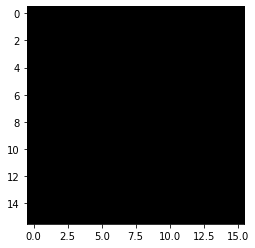

In [149]:
plt.imshow(predicted_mid_result.reshape((16,16,3)))

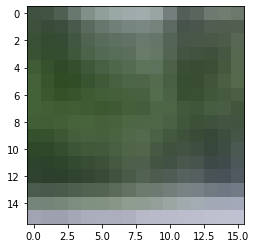

In [150]:
plt.imshow(imageio.imread("/home/niaki/Code/ImageNet/tiny-imagenet-200/tiny_validation16/class0/patch000064.png"))

In [118]:
np.max(predicted_mid_result)

1.0

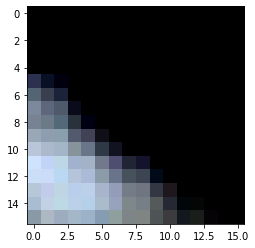

In [140]:
plt.imshow((predicted_mid_result/np.max(predicted_mid_result)).reshape((16,16,3)))

In [158]:
autoencoder.predict(imageio.imread("/home/niaki/Code/ImageNet/tiny-imagenet-200/tiny_validation16/class0/patch000010.png").reshape((1,16,16,3)))

array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
       